In [1]:
# библиотеки
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
# папки
image_folder = '/work_dir/data/team_classification_data/frames'
json_file = '/work_dir/data/team_classification_data/bboxes.json'

In [3]:
# прочитам json-файл
with open(json_file, 'r', encoding='utf-8') as f:
    json_data = json.load(f)

# и перевдем его в пандас, просто так мне удобнее
columns=['image_id', 'player_num', 'bb_x_norm', 'bb_y_norm', 'bb_w_norm', 'bb_h_norm', 'team_current']
df = pd.DataFrame(columns=columns)
r = 0
for image_id, v in json_data.items():
    for player_num, v2 in json_data[image_id].items():
        bb_norm = json_data[image_id][player_num]['box']
        team_current = json_data[image_id][player_num]['team']
        df.loc[r] = [image_id, player_num] + bb_norm + [team_current]
        r += 1

# и еще сразу передем координаты в абсолютные формата [x1,y1,x2,y2]
abs_coord_columns = ['bb_x1', 'bb_y1', 'bb_x2', 'bb_y2']
df.loc[:,abs_coord_columns] = 0
for i in df.index:
    img = cv2.imread(
        os.path.join(image_folder, df.loc[i, 'image_id'] + '.jpeg')
    )
    df.loc[i, 'bb_x1'] = abs(int(df.loc[i, 'bb_x_norm'] * img.shape[1]))
    df.loc[i, 'bb_y1'] = abs(int(df.loc[i, 'bb_y_norm'] * img.shape[0]))
    df.loc[i, 'bb_x2'] = df.loc[i, 'bb_x1'] + int(df.loc[i, 'bb_w_norm'] * img.shape[1])
    df.loc[i, 'bb_y2'] = df.loc[i, 'bb_y1'] + int(df.loc[i, 'bb_h_norm'] * img.shape[0])
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,bb_y2
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,407
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,534
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,442
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,484
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,597


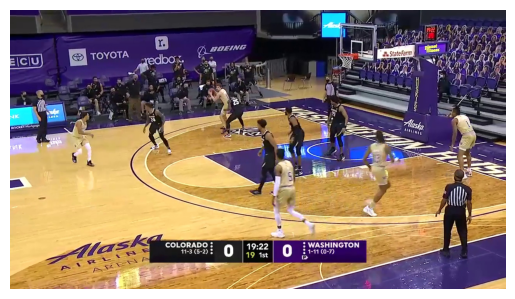

In [4]:
# посмотрим что внутри изображений
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)

plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

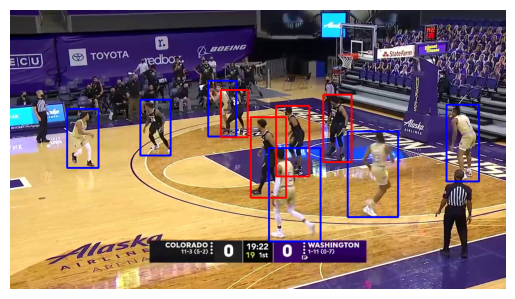

In [5]:
# А если отрисовать боксы?
curr_image_id = df.loc[0, 'image_id']
team_color = [
    (255, 0, 0),
    (0, 0, 255)
]

img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)
for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['bb_x1'], row['bb_y1']),
        (row['bb_x2'], row['bb_y2']),
        team_color[row['team_current']],
        3
    )
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

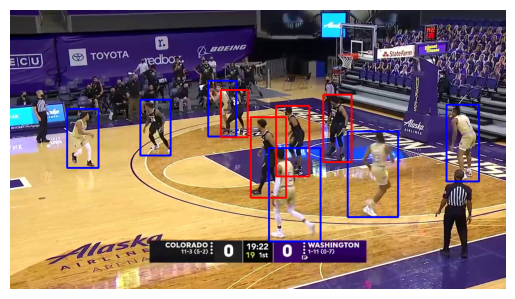

In [6]:
curr_image_id = df.loc[0, 'image_id']
team_color = [
    (255, 0, 0),
    (0, 0, 255)
]

img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)

for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['bb_x1'], row['bb_y1']),
        (row['bb_x2'], row['bb_y2']),
        team_color[row['team_current']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [7]:
# Собираем среднее значение цветов со всех bb отдельно по каналам
mean_bb_columns = ['mean_r', 'mean_g', 'mean_b']
df.loc[:,mean_bb_columns] = 0.0
for index, row in df.iterrows():
    img = cv2.imread(
        os.path.join(image_folder, row['image_id'] + '.jpeg')
    )
    cut_bbox = img[row['bb_y1']:row['bb_y2'], row['bb_x1']:row['bb_x2'], :]
    df.loc[index, 'mean_r'] = cut_bbox[:,:,2].mean()
    df.loc[index, 'mean_g'] = cut_bbox[:,:,1].mean()
    df.loc[index, 'mean_b'] = cut_bbox[:,:,0].mean()
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,bb_y2,mean_r,mean_g,mean_b
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,407,160.885315,138.079678,106.840400
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,534,163.319248,135.734911,114.425444
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,442,129.299603,109.305315,104.573773
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,484,126.071059,102.998151,88.243766
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,597,170.751849,146.937011,120.818551


In [8]:
# классфикация с помощью k-means
df.loc[:,'team_rgb_kmeans'] = 0
for image_id in df['image_id'].unique():
    slice_df = df.loc[df['image_id'] == image_id, ['mean_r', 'mean_g', 'mean_b']]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slice_df)
    df.loc[df['image_id'] == image_id, 'team_rgb_kmeans'] = kmeans.labels_
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,bb_y2,mean_r,mean_g,mean_b,team_rgb_kmeans
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,407,160.885315,138.079678,106.840400,1
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,534,163.319248,135.734911,114.425444,1
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,442,129.299603,109.305315,104.573773,0
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,484,126.071059,102.998151,88.243766,0
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,597,170.751849,146.937011,120.818551,1


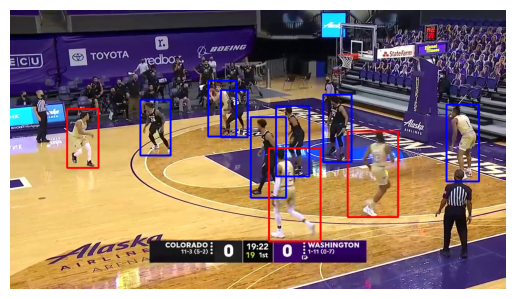

In [9]:
# отрисует получившийся результат
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)
for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['bb_x1'], row['bb_y1']),
        (row['bb_x2'], row['bb_y2']),
        team_color[row['team_rgb_kmeans']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [10]:
# теперь HSV
mean_bb_columns = ['mean_h', 'mean_s', 'mean_v']
df.loc[:,mean_bb_columns] = 0.0
for index, row in df.iterrows():
    img = cv2.imread(
        os.path.join(image_folder, row['image_id'] + '.jpeg')
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    cut_bbox = img[row['bb_y1']:row['bb_y2'], row['bb_x1']:row['bb_x2'], :]
    df.loc[index, 'mean_h'] = cut_bbox[:,:,0].mean()
    df.loc[index, 'mean_s'] = cut_bbox[:,:,1].mean()
    df.loc[index, 'mean_v'] = cut_bbox[:,:,2].mean()
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,bb_y2,mean_r,mean_g,mean_b,team_rgb_kmeans,mean_h,mean_s,mean_v
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,407,160.885315,138.079678,106.840400,1,54.859324,99.164799,164.534276
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,534,163.319248,135.734911,114.425444,1,48.387574,119.856874,180.298712
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,442,129.299603,109.305315,104.573773,0,68.447992,94.352994,135.939394
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,484,126.071059,102.998151,88.243766,0,58.875898,116.847105,135.803466
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,597,170.751849,146.937011,120.818551,1,51.157333,112.664836,184.870777


In [11]:
# классфикация с помощью k-means
df.loc[:,'team_hsv_kmeans'] = 0
for image_id in df['image_id'].unique():
    slice_df = df.loc[df['image_id'] == image_id, ['mean_h', 'mean_s', 'mean_v']]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slice_df)
    df.loc[df['image_id'] == image_id, 'team_hsv_kmeans'] = kmeans.labels_
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,bb_y2,mean_r,mean_g,mean_b,team_rgb_kmeans,mean_h,mean_s,mean_v,team_hsv_kmeans
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,407,160.885315,138.079678,106.840400,1,54.859324,99.164799,164.534276,0
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,534,163.319248,135.734911,114.425444,1,48.387574,119.856874,180.298712,0
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,442,129.299603,109.305315,104.573773,0,68.447992,94.352994,135.939394,0
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,484,126.071059,102.998151,88.243766,0,58.875898,116.847105,135.803466,0
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,597,170.751849,146.937011,120.818551,1,51.157333,112.664836,184.870777,0


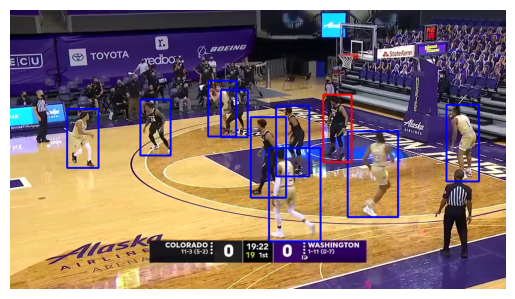

In [12]:
# отрисует получившийся результат
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)
for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['bb_x1'], row['bb_y1']),
        (row['bb_x2'], row['bb_y2']),
        team_color[row['team_hsv_kmeans']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [13]:
# теперь гистограмма по rgb
bins = 8
hist_rgb_columns = [f'hist_rgb_{i}' for i in range(bins)]
df.loc[:,hist_rgb_columns] = 0.0
for index, row in df.iterrows():
    img = cv2.imread(
        os.path.join(image_folder, row['image_id'] + '.jpeg')
    )
    cut_bbox = img[row['bb_y1']:row['bb_y2'], row['bb_x1']:row['bb_x2'], :]
    df.loc[index, hist_rgb_columns] = cv2.calcHist([cut_bbox],[0],None,[bins],[0,256])[:,0]
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,...,mean_v,team_hsv_kmeans,hist_rgb_0,hist_rgb_1,hist_rgb_2,hist_rgb_3,hist_rgb_4,hist_rgb_5,hist_rgb_6,hist_rgb_7
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,...,164.534276,0,743.0,1529.0,2016.0,4886.0,1878.0,480.0,321.0,459.0
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,...,180.298712,0,660.0,3540.0,10166.0,4811.0,3678.0,2151.0,1387.0,2337.0
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,...,135.939394,0,1525.0,2428.0,4373.0,3566.0,1678.0,1252.0,964.0,846.0
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,...,135.803466,0,2369.0,2951.0,7007.0,3781.0,907.0,519.0,485.0,909.0
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,...,184.870777,0,1201.0,3462.0,8938.0,6113.0,4791.0,2586.0,1763.0,3199.0


In [14]:
# классфикация с помощью k-means
df.loc[:,'team_hist_rgb_kmeans'] = 0
for image_id in df['image_id'].unique():
    slice_df = df.loc[df['image_id'] == image_id, hist_rgb_columns]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slice_df)
    df.loc[df['image_id'] == image_id, 'team_hist_rgb_kmeans'] = kmeans.labels_
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,...,team_hsv_kmeans,hist_rgb_0,hist_rgb_1,hist_rgb_2,hist_rgb_3,hist_rgb_4,hist_rgb_5,hist_rgb_6,hist_rgb_7,team_hist_rgb_kmeans
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,...,0,743.0,1529.0,2016.0,4886.0,1878.0,480.0,321.0,459.0,0
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,...,0,660.0,3540.0,10166.0,4811.0,3678.0,2151.0,1387.0,2337.0,1
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,...,0,1525.0,2428.0,4373.0,3566.0,1678.0,1252.0,964.0,846.0,0
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,...,0,2369.0,2951.0,7007.0,3781.0,907.0,519.0,485.0,909.0,0
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,...,0,1201.0,3462.0,8938.0,6113.0,4791.0,2586.0,1763.0,3199.0,1


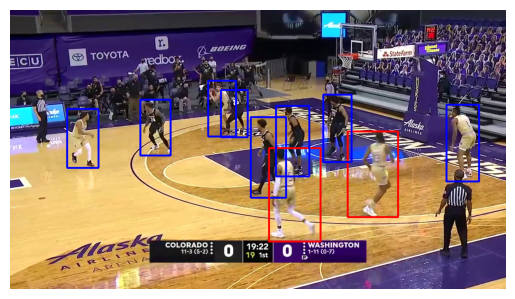

In [15]:
# отрисуем получившийся результат
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)
for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['bb_x1'], row['bb_y1']),
        (row['bb_x2'], row['bb_y2']),
        team_color[row['team_hist_rgb_kmeans']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [16]:
# теперь гистограмма по hsv
bins = 8
hist_hsv_columns = [f'hist_hsv_{i}' for i in range(bins)]
df.loc[:,hist_hsv_columns] = 0.0
for index, row in df.iterrows():
    img = cv2.imread(
        os.path.join(image_folder, row['image_id'] + '.jpeg')
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    cut_bbox = img[row['bb_y1']:row['bb_y2'], row['bb_x1']:row['bb_x2'], :]
    df.loc[index, hist_hsv_columns] = cv2.calcHist([cut_bbox],[0],None,[bins],[0,256])[:,0]
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,...,hist_rgb_7,team_hist_rgb_kmeans,hist_hsv_0,hist_hsv_1,hist_hsv_2,hist_hsv_3,hist_hsv_4,hist_hsv_5,hist_hsv_6,hist_hsv_7
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,...,459.0,0,8512.0,2.0,1.0,1400.0,1694.0,703.0,0.0,0.0
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,...,2337.0,1,20851.0,27.0,35.0,4111.0,2601.0,1105.0,0.0,0.0
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,...,846.0,0,9309.0,33.0,13.0,2112.0,4020.0,1145.0,0.0,0.0
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,...,909.0,0,11969.0,72.0,64.0,1714.0,4298.0,811.0,0.0,0.0
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,...,3199.0,1,22467.0,87.0,353.0,4362.0,3437.0,1347.0,0.0,0.0


In [17]:
# классфикация с помощью k-means
df.loc[:,'team_hist_hsv_kmeans'] = 0
for image_id in df['image_id'].unique():
    slice_df = df.loc[df['image_id'] == image_id, hist_rgb_columns]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slice_df)
    df.loc[df['image_id'] == image_id, 'team_hist_hsv_kmeans'] = kmeans.labels_
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,...,team_hist_rgb_kmeans,hist_hsv_0,hist_hsv_1,hist_hsv_2,hist_hsv_3,hist_hsv_4,hist_hsv_5,hist_hsv_6,hist_hsv_7,team_hist_hsv_kmeans
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,...,0,8512.0,2.0,1.0,1400.0,1694.0,703.0,0.0,0.0,0
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,...,1,20851.0,27.0,35.0,4111.0,2601.0,1105.0,0.0,0.0,1
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,...,0,9309.0,33.0,13.0,2112.0,4020.0,1145.0,0.0,0.0,0
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,...,0,11969.0,72.0,64.0,1714.0,4298.0,811.0,0.0,0.0,0
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,...,1,22467.0,87.0,353.0,4362.0,3437.0,1347.0,0.0,0.0,1


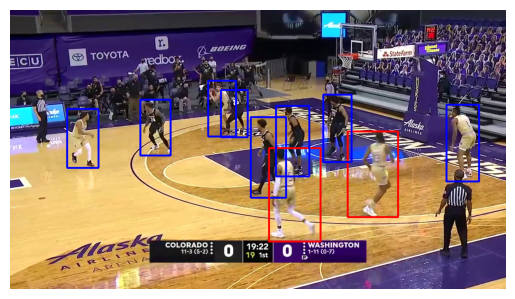

In [18]:
# отрисуем получившийся результат
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)
for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['bb_x1'], row['bb_y1']),
        (row['bb_x2'], row['bb_y2']),
        team_color[row['team_hist_hsv_kmeans']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [19]:
print(df.columns)

Index(['image_id', 'player_num', 'bb_x_norm', 'bb_y_norm', 'bb_w_norm',
       'bb_h_norm', 'team_current', 'bb_x1', 'bb_y1', 'bb_x2', 'bb_y2',
       'mean_r', 'mean_g', 'mean_b', 'team_rgb_kmeans', 'mean_h', 'mean_s',
       'mean_v', 'team_hsv_kmeans', 'hist_rgb_0', 'hist_rgb_1', 'hist_rgb_2',
       'hist_rgb_3', 'hist_rgb_4', 'hist_rgb_5', 'hist_rgb_6', 'hist_rgb_7',
       'team_hist_rgb_kmeans', 'hist_hsv_0', 'hist_hsv_1', 'hist_hsv_2',
       'hist_hsv_3', 'hist_hsv_4', 'hist_hsv_5', 'hist_hsv_6', 'hist_hsv_7',
       'team_hist_hsv_kmeans'],
      dtype='object')


In [20]:
# проверим точность
y_true = df.loc[:, 'team_current']
y_mean_rgb = df.loc[:, 'team_rgb_kmeans']
y_mean_hsv = df.loc[:, 'team_hsv_kmeans']
y_hist_rgb = df.loc[:, 'team_hist_rgb_kmeans']
y_hist_hsv = df.loc[:, 'team_hist_hsv_kmeans']

# так как k-means распределяет классы так как ему нравится, то сначала проверим прямой ответ модели,
# а затем проверим инвертированный вариант и выберем лучший
accuracy_mean_rgb = [
    accuracy_score(y_true, y_mean_rgb),
    accuracy_score(y_true, 1 - y_mean_rgb)
]
accuracy_mean_hsv = [
    accuracy_score(y_true, y_mean_hsv),
    accuracy_score(y_true, 1 - y_mean_hsv)
]
accuracy_hist_rgb = [
    accuracy_score(y_true, y_hist_rgb),
    accuracy_score(y_true, 1 - y_hist_rgb)
]
accuracy_hist_hsv = [
    accuracy_score(y_true, y_hist_hsv),
    accuracy_score(y_true, 1 - y_hist_hsv)
]
print('Точность для среднего RGB:', max(accuracy_mean_rgb))
print('Точность для среднего HSV:', max(accuracy_mean_hsv))
print('Точность для гистограммы RGB:', max(accuracy_hist_rgb))
print('Точность для гистограммы HSV:', max(accuracy_hist_hsv))

Точность для среднего RGB: 0.51
Точность для среднего HSV: 0.528
Точность для гистограммы RGB: 0.518
Точность для гистограммы HSV: 0.518


In [21]:
# ну чтож. Предложенные способы не помогли, значит надо искать другой путь.
# основную проблему вижу в том, что в области боксов слишком много лишней информации
# попробуем уменьшить боксы на половину и совместить центр получившегося бокса с исходным

abs_coord_new_bb_columns = ['new_bb_x1', 'new_bb_y1', 'new_bb_x2', 'new_bb_y2']
df.loc[:,abs_coord_new_bb_columns] = 0
for index, row in df.iterrows():
    x_width = (df.loc[index, 'bb_x2'] - df.loc[index, 'bb_x1']) // 2
    y_width = (df.loc[index, 'bb_y2'] - df.loc[index, 'bb_y1']) // 2
    df.loc[index, 'new_bb_x1'] = df.loc[index, 'bb_x1'] + x_width // 2
    df.loc[index, 'new_bb_x2'] = df.loc[index, 'new_bb_x1'] + x_width
    df.loc[index, 'new_bb_y1'] = df.loc[index, 'bb_y1'] + y_width // 2
    df.loc[index, 'new_bb_y2'] = df.loc[index, 'new_bb_y1'] + y_width

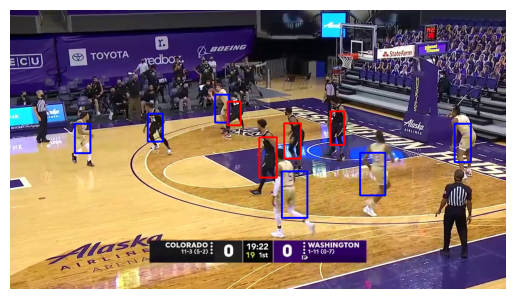

In [22]:
# отрисуем новые боксы
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)

for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['new_bb_x1'], row['new_bb_y1']),
        (row['new_bb_x2'], row['new_bb_y2']),
        team_color[row['team_current']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [23]:
# Собираем среднее значение цветов hsv со всех новых bb отдельно по каналам
mean_bb_columns = ['new_mean_h', 'new_mean_s', 'new_mean_v']
df.loc[:,mean_bb_columns] = 0.0
for index, row in df.iterrows():
    img = cv2.imread(
        os.path.join(image_folder, row['image_id'] + '.jpeg')
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    cut_bbox = img[row['new_bb_y1']:row['new_bb_y2'], row['new_bb_x1']:row['new_bb_x2'], :]
    df.loc[index, 'new_mean_h'] = cut_bbox[:,:,0].mean()
    df.loc[index, 'new_mean_s'] = cut_bbox[:,:,1].mean()
    df.loc[index, 'new_mean_v'] = cut_bbox[:,:,2].mean()
df.head()

,image_id,player_num,bb_x_norm,bb_y_norm,bb_w_norm,bb_h_norm,team_current,bb_x1,bb_y1,bb_x2,...,hist_hsv_6,hist_hsv_7,team_hist_hsv_kmeans,new_bb_x1,new_bb_y1,new_bb_x2,new_bb_y2,new_mean_h,new_mean_s,new_mean_v
0,1310,0,0.115335,0.355553,0.063924,0.211998,0,147,255,228,...,0.0,0.0,0,167,293,207,369,35.799342,94.836184,191.232895
1,1310,1,0.681132,0.435348,0.102316,0.307701,0,871,313,1001,...,0.0,0.0,1,903,368,968,478,35.510909,111.497622,182.375804
2,1310,2,0.879834,0.339752,0.065729,0.275233,0,1126,244,1210,...,0.0,0.0,0,1147,293,1189,392,49.074315,95.886724,148.034632
3,1310,3,0.485171,0.383975,0.071188,0.289429,1,621,276,712,...,0.0,0.0,0,643,328,688,432,78.555983,93.296581,79.800641
4,1310,4,0.521896,0.495190,0.104673,0.335104,0,668,356,801,...,0.0,0.0,1,701,416,767,536,34.725505,112.323106,188.951010


In [24]:
# классфикация с помощью k-means
df.loc[:,'team_new_bb_mean_hsv_kmeans'] = 0
for image_id in df['image_id'].unique():
    slice_df = df.loc[df['image_id'] == image_id, mean_bb_columns]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slice_df)
    df.loc[df['image_id'] == image_id, 'team_new_bb_mean_hsv_kmeans'] = kmeans.labels_

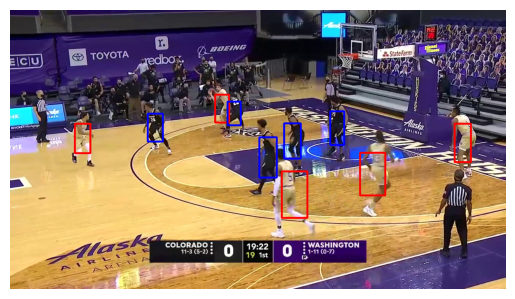

In [25]:
# отрисуем результат
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)

for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['new_bb_x1'], row['new_bb_y1']),
        (row['new_bb_x2'], row['new_bb_y2']),
        team_color[row['team_new_bb_mean_hsv_kmeans']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [26]:
# Проверим точность с таким подходом
y_new_bb_mean_hsv = df.loc[:, 'team_new_bb_mean_hsv_kmeans']
accuracy_new_bb_mean_hsv = [
    accuracy_score(y_true, y_new_bb_mean_hsv),
    accuracy_score(y_true, 1 - y_new_bb_mean_hsv)
]
print('Точность для среднего HSV уменьшиных bb:', max(accuracy_new_bb_mean_hsv))

Точность для среднего HSV уменьшиных bb: 0.531


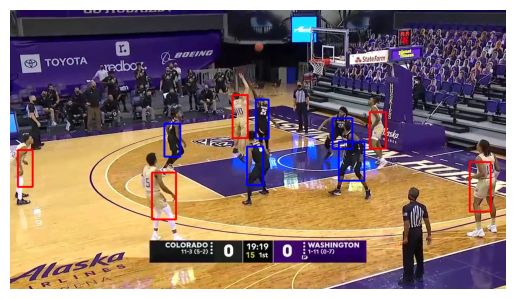

In [27]:
# Ну а теперь на тестовом датасете
image_folder = '/work_dir/data/team_classification_test/frames'
json_file = '/work_dir/data/team_classification_test/test_bboxes.json'

# читаем json
with open(json_file, 'r', encoding='utf-8') as f:
    json_data = json.load(f)

# переводим json в pandas DF
columns=['image_id', 'player_num', 'bb_x_norm', 'bb_y_norm', 'bb_w_norm', 'bb_h_norm']
df = pd.DataFrame(columns=columns)
r = 0
for image_id, v in json_data.items():
    for player_num, v2 in json_data[image_id].items():
        bb_norm = json_data[image_id][player_num]['box']
        df.loc[r] = [image_id, player_num] + bb_norm
        r += 1

# считаем координаты для уменьшиных bb
abs_coord_new_bb_columns = ['new_bb_x1', 'new_bb_y1', 'new_bb_x2', 'new_bb_y2']
df.loc[:,abs_coord_new_bb_columns] = 0
for i in df.index:
    img = cv2.imread(
        os.path.join(image_folder, df.loc[i, 'image_id'] + '.jpeg')
    )
    bb_x1 = abs(int(df.loc[i, 'bb_x_norm'] * img.shape[1]))
    bb_y1 = abs(int(df.loc[i, 'bb_y_norm'] * img.shape[0]))
    bb_x2 = bb_x1 + int(df.loc[i, 'bb_w_norm'] * img.shape[1])
    bb_y2 = bb_y1 + int(df.loc[i, 'bb_h_norm'] * img.shape[0])
    x_width = (bb_x2 - bb_x1) // 2
    y_width = (bb_y2 - bb_y1) // 2
    df.loc[i, 'new_bb_x1'] = bb_x1 + x_width // 2
    df.loc[i, 'new_bb_x2'] = df.loc[i, 'new_bb_x1'] + x_width
    df.loc[i, 'new_bb_y1'] = bb_y1 + y_width // 2
    df.loc[i, 'new_bb_y2'] = df.loc[i, 'new_bb_y1'] + y_width

# считаем среднее по hsv
mean_bb_columns = ['new_mean_h', 'new_mean_s', 'new_mean_v']
df.loc[:,mean_bb_columns] = 0.0
for index, row in df.iterrows():
    img = cv2.imread(
        os.path.join(image_folder, row['image_id'] + '.jpeg')
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    cut_bbox = img[row['new_bb_y1']:row['new_bb_y2'], row['new_bb_x1']:row['new_bb_x2'], :]
    df.loc[index, 'new_mean_h'] = cut_bbox[:,:,0].mean()
    df.loc[index, 'new_mean_s'] = cut_bbox[:,:,1].mean()
    df.loc[index, 'new_mean_v'] = cut_bbox[:,:,2].mean()

# считаем k-means
df.loc[:,'team_new_bb_mean_hsv_kmeans'] = 0
for image_id in df['image_id'].unique():
    slice_df = df.loc[df['image_id'] == image_id, mean_bb_columns]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(slice_df)
    df.loc[df['image_id'] == image_id, 'team_new_bb_mean_hsv_kmeans'] = kmeans.labels_

# отрисовываем
curr_image_id = df.loc[0, 'image_id']
img = cv2.imread(
    os.path.join(image_folder, curr_image_id + '.jpeg')
)

for _, row in df.loc[df['image_id'] == curr_image_id].iterrows():
    img = cv2.rectangle(
        img,
        (row['new_bb_x1'], row['new_bb_y1']),
        (row['new_bb_x2'], row['new_bb_y2']),
        team_color[row['team_new_bb_mean_hsv_kmeans']],
        3
    )
    
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [29]:
# собирем json для тестового датасета
result = dict()
for image_id in df['image_id'].unique():
    result[image_id] = dict()
    t_df = df.loc[df['image_id'] == image_id]
    for player_num in t_df['player_num'].unique():
        team = df.loc[(df['image_id'] == image_id) & (df['player_num'] == player_num), 'team_new_bb_mean_hsv_kmeans'].iloc[0]
        result[image_id].update({str(player_num):{"team": int(team)}})

with open('test_predict.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, indent=4)